In [77]:
import os
import requests
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [78]:
load_dotenv()

True

In [79]:
model = ChatOpenAI()

In [80]:
class LLMState(TypedDict):
    category : str
    query : str
    response : str
    location: str
    weather: str

In [81]:
def routeragent(state: LLMState) -> LLMState:
    query = state["query"]
    prompt = f"Classify the following question into either Science, Weather or General \n {query}"

    category = model.invoke(prompt).content

    state["category"] = category
    return state

In [82]:
def science_query(state: LLMState) -> LLMState:
    query = state["query"]
    if state["category"] == "Science":
        prompt = f"Answer the following question. {query}"
        response = model.invoke(prompt).content
        state["response"] = response
        return state

In [83]:
def weather_query(state: LLMState) -> LLMState:
    query = state["query"]
    if state["category"] == "Weather":

        prompt1 = f"Which location is this query for {query}?"
        location = model.invoke(prompt1).content
        state["location"] = location

        weather_details = get_weather_details(location)

        prompt2 = f"Answer the following question. {query} with {weather_details}"
        response = model.invoke(prompt2).content

        state["response"] = response
        return state

In [84]:
def get_weather_details(location:str):
    API_KEY = ""

    response = requests.get(f"http://api.weatherapi.com/v1/current.json?key={API_KEY}&q={location}")
    data = response.json()

    return data

In [94]:
def general_query(state: LLMState) -> LLMState:
    query = state["query"]
    if state["category"] == "General":
        prompt = f"Answer the following question. {query}"
        response = model.invoke(prompt).content
        state["response"] = response
        state["location"] = ""
        return state

In [95]:
# create a state
graph = StateGraph(LLMState)

graph.add_node("routeragent", routeragent)
graph.add_node("science_query", science_query)
graph.add_node("weather_query", weather_query)
graph.add_node("general_query", general_query)

graph.add_edge(START, "routeragent")
graph.add_edge("routeragent", "science_query")
graph.add_edge("routeragent", "weather_query")
graph.add_edge("routeragent", "general_query")
graph.add_edge("science_query", END)
graph.add_edge("weather_query", END)
graph.add_edge("general_query", END)

workflow = graph.compile()

In [92]:
query = "Who is the father of the nation of India?"

In [96]:
initial_state = {"query": query}

final_state = workflow.invoke(initial_state)

print (f"location: {final_state['location']}")
print(f"Category: {final_state['category']}")
print(f"Question: {final_state['query']}")
print(f"Answer: {final_state['response']}")

location: 
Category: General
Question: Who is the father of the nation of India?
Answer: Mahatma Gandhi is often referred to as the "Father of the Nation" in India.


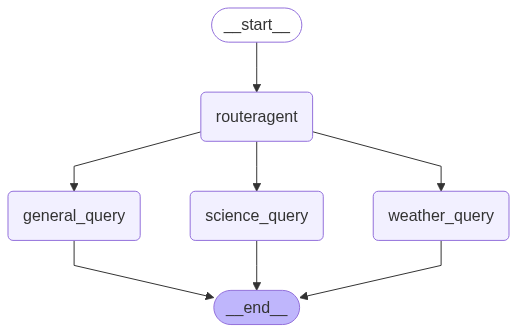

In [89]:
from IPython.display import display, Image
Image(workflow.get_graph().draw_mermaid_png())